In [12]:
## Import Packages
import numpy as np
import _pickle as pk
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
exps = ['iga-sst-1xco2','iga-sst-4xco2','idj-sst-4xco2',\
        'iga-dsst-4xco2','5pi-sst-1xco2','5a4-sst-4xco2','5pi-dsst-4xco2']

Source = 'Data/CanESM5_p2/Custom/Climatology/'
clisccp = dict()
for i in range(len(exps)):
    clisccp[exps[i]] = np.nanmean(\
        pk.load(open(Source+'CanESM5_p2_'+exps[i]+'_clisccp_Climo.pi','rb')),axis=0)

In [3]:
#define grid and weights
lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

tau = [0.,0.3,1.3,3.6,9.4,23.,60.,380.]
ctp = [1000,800,680,560,440,310,180,50]

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat,(lon.size,1)).T

In [4]:
lat[28:36]

array([-9.76266667, -6.97333333, -4.184     , -1.39466667,  1.39466667,
        4.184     ,  6.97333333,  9.76266667])

In [5]:
dCLD = {}
dCLD['2SST'] = clisccp['idj-sst-4xco2']-clisccp['iga-sst-1xco2']
dCLD['2SSTu'] = clisccp['iga-dsst-4xco2']-clisccp['iga-sst-1xco2']
dCLD['5SST'] = clisccp['5a4-sst-4xco2']-clisccp['5pi-sst-1xco2']
dCLD['5SSTu'] = clisccp['5pi-dsst-4xco2']-clisccp['5pi-sst-1xco2']

In [6]:
dCLD_sum = {}
dCLD_gam = {}
dCLD_plot = {}
for exp in dCLD.keys():
    dCLD_sum[exp] = np.nansum(dCLD[exp],axis=(0,1))
    dCLD_gam[exp] = np.average(dCLD_sum[exp],weights=coslat)
    dCLD_plot[exp] = np.concatenate((dCLD_sum[exp][:,64:],dCLD_sum[exp][:,:64]),axis=1)
    dCLD_plot[exp],lon_cyc = add_cyclic_point(dCLD_plot[exp],lon)
    print(np.amax(dCLD_plot[exp]))
    print(np.amin(dCLD_plot[exp]))

32.70578841526296
-24.4313268054516
9.086817086157055
-18.42576288583999
24.67634960015679
-39.828690888334926
12.047193861132191
-22.44809067758551


In [7]:
hist = {}
for exp in dCLD.keys():
    hist[exp] = np.average(dCLD[exp][:,:,28:36,:],\
        weights=np.tile(coslat[None,None,:,:],(7,7,1,1))[:,:,28:36,:],axis=(2,3))
    #print(np.amax(hist[exp]))
    #print(np.amin(hist[exp]))

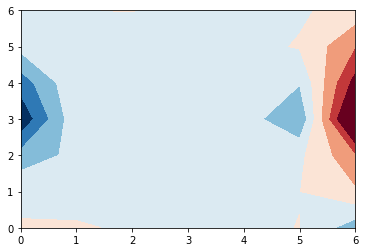

In [8]:
bounds = np.arange(-2,2.1,0.5)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
hist_cont = plt.contourf(hist['2SST'],bounds,cmap=cmap,norm=norm,extend='both')

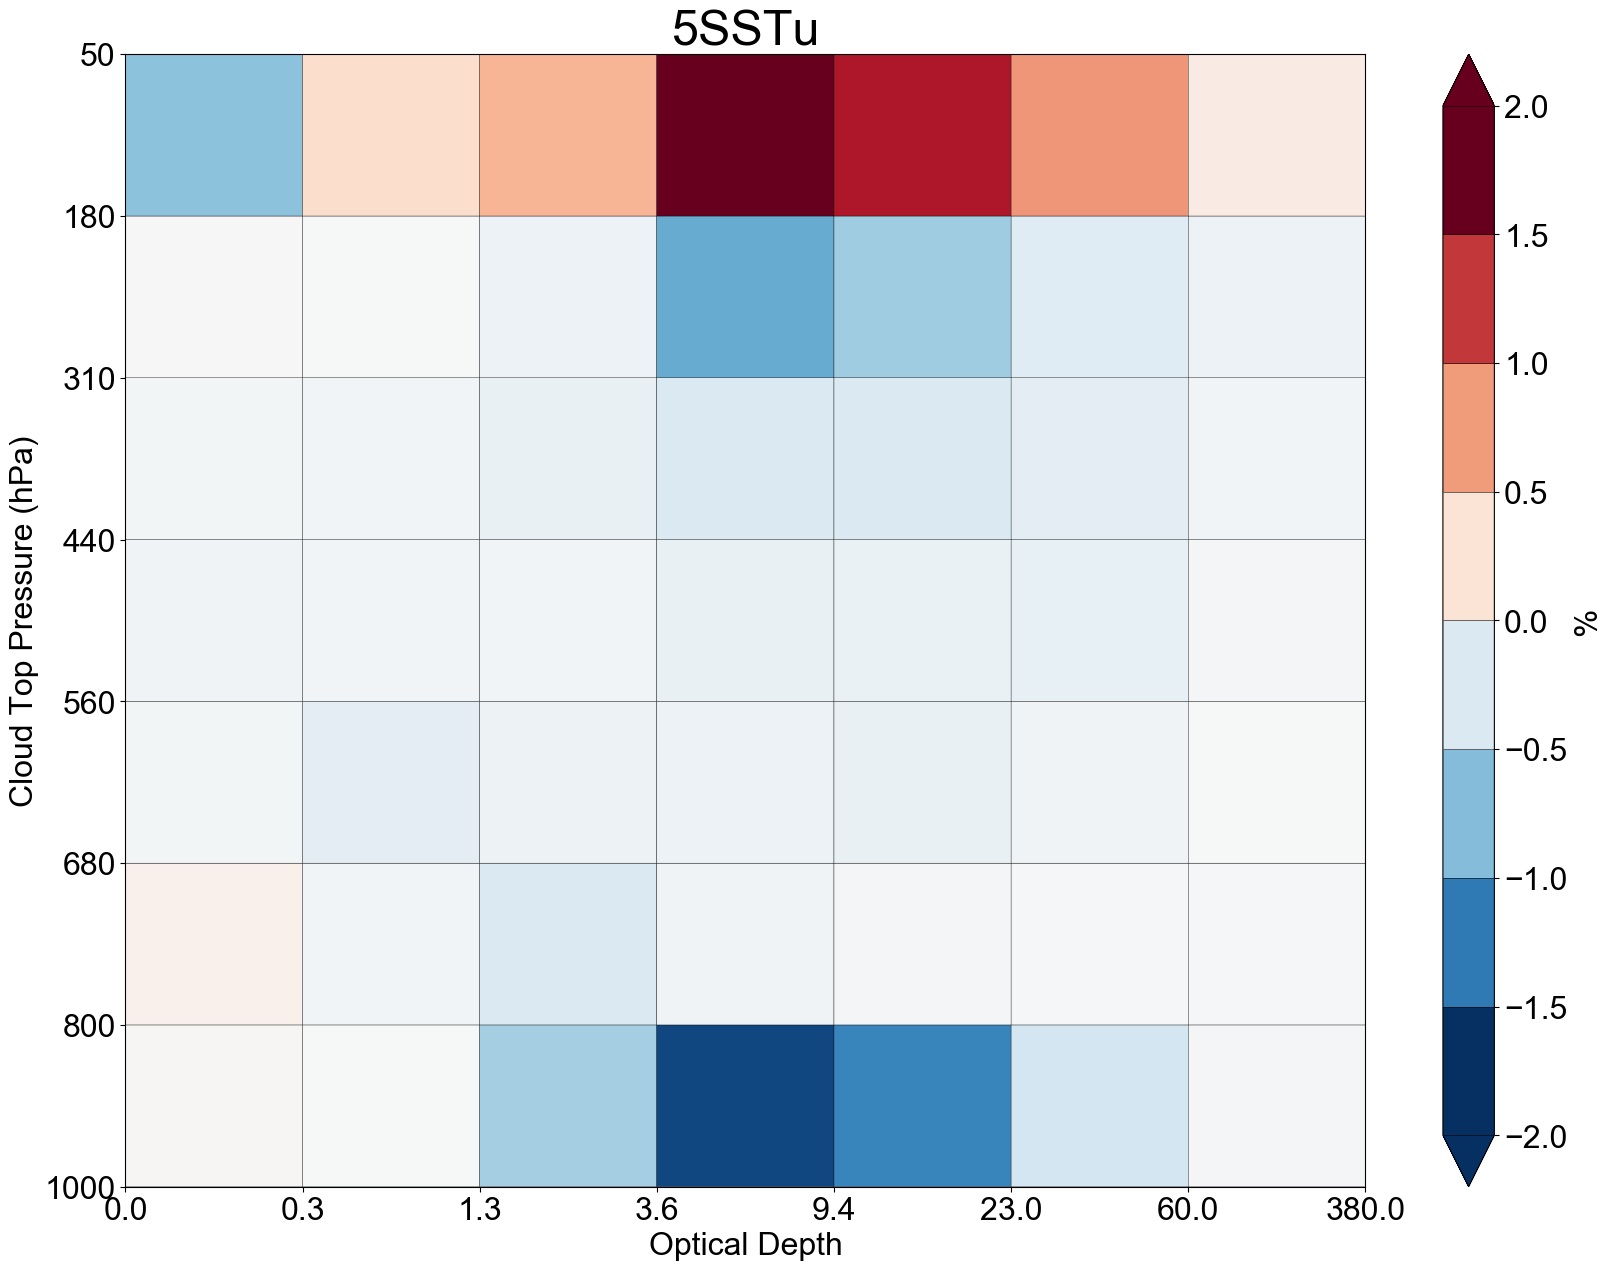

In [30]:
fig = plt.figure(figsize=(20,15),dpi=100)
ax = ax = fig.add_subplot(111)
plt.title('5SSTu',fontsize=35)
hist_dat = plt.pcolor(np.swapaxes(hist['5SSTu'],0,1),cmap=cmap,vmin=-2,vmax=2,edgecolors='k')
plt.xticks(np.arange(8), tau)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')
plt.ylabel('Cloud Top Pressure (hPa)')
cb = plt.colorbar(hist_cont,ticks=bounds,drawedges=True,label='%')
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")

plt.savefig('CanESM5_Custom_CLD_5SSTu.png',bbox_inches='tight')

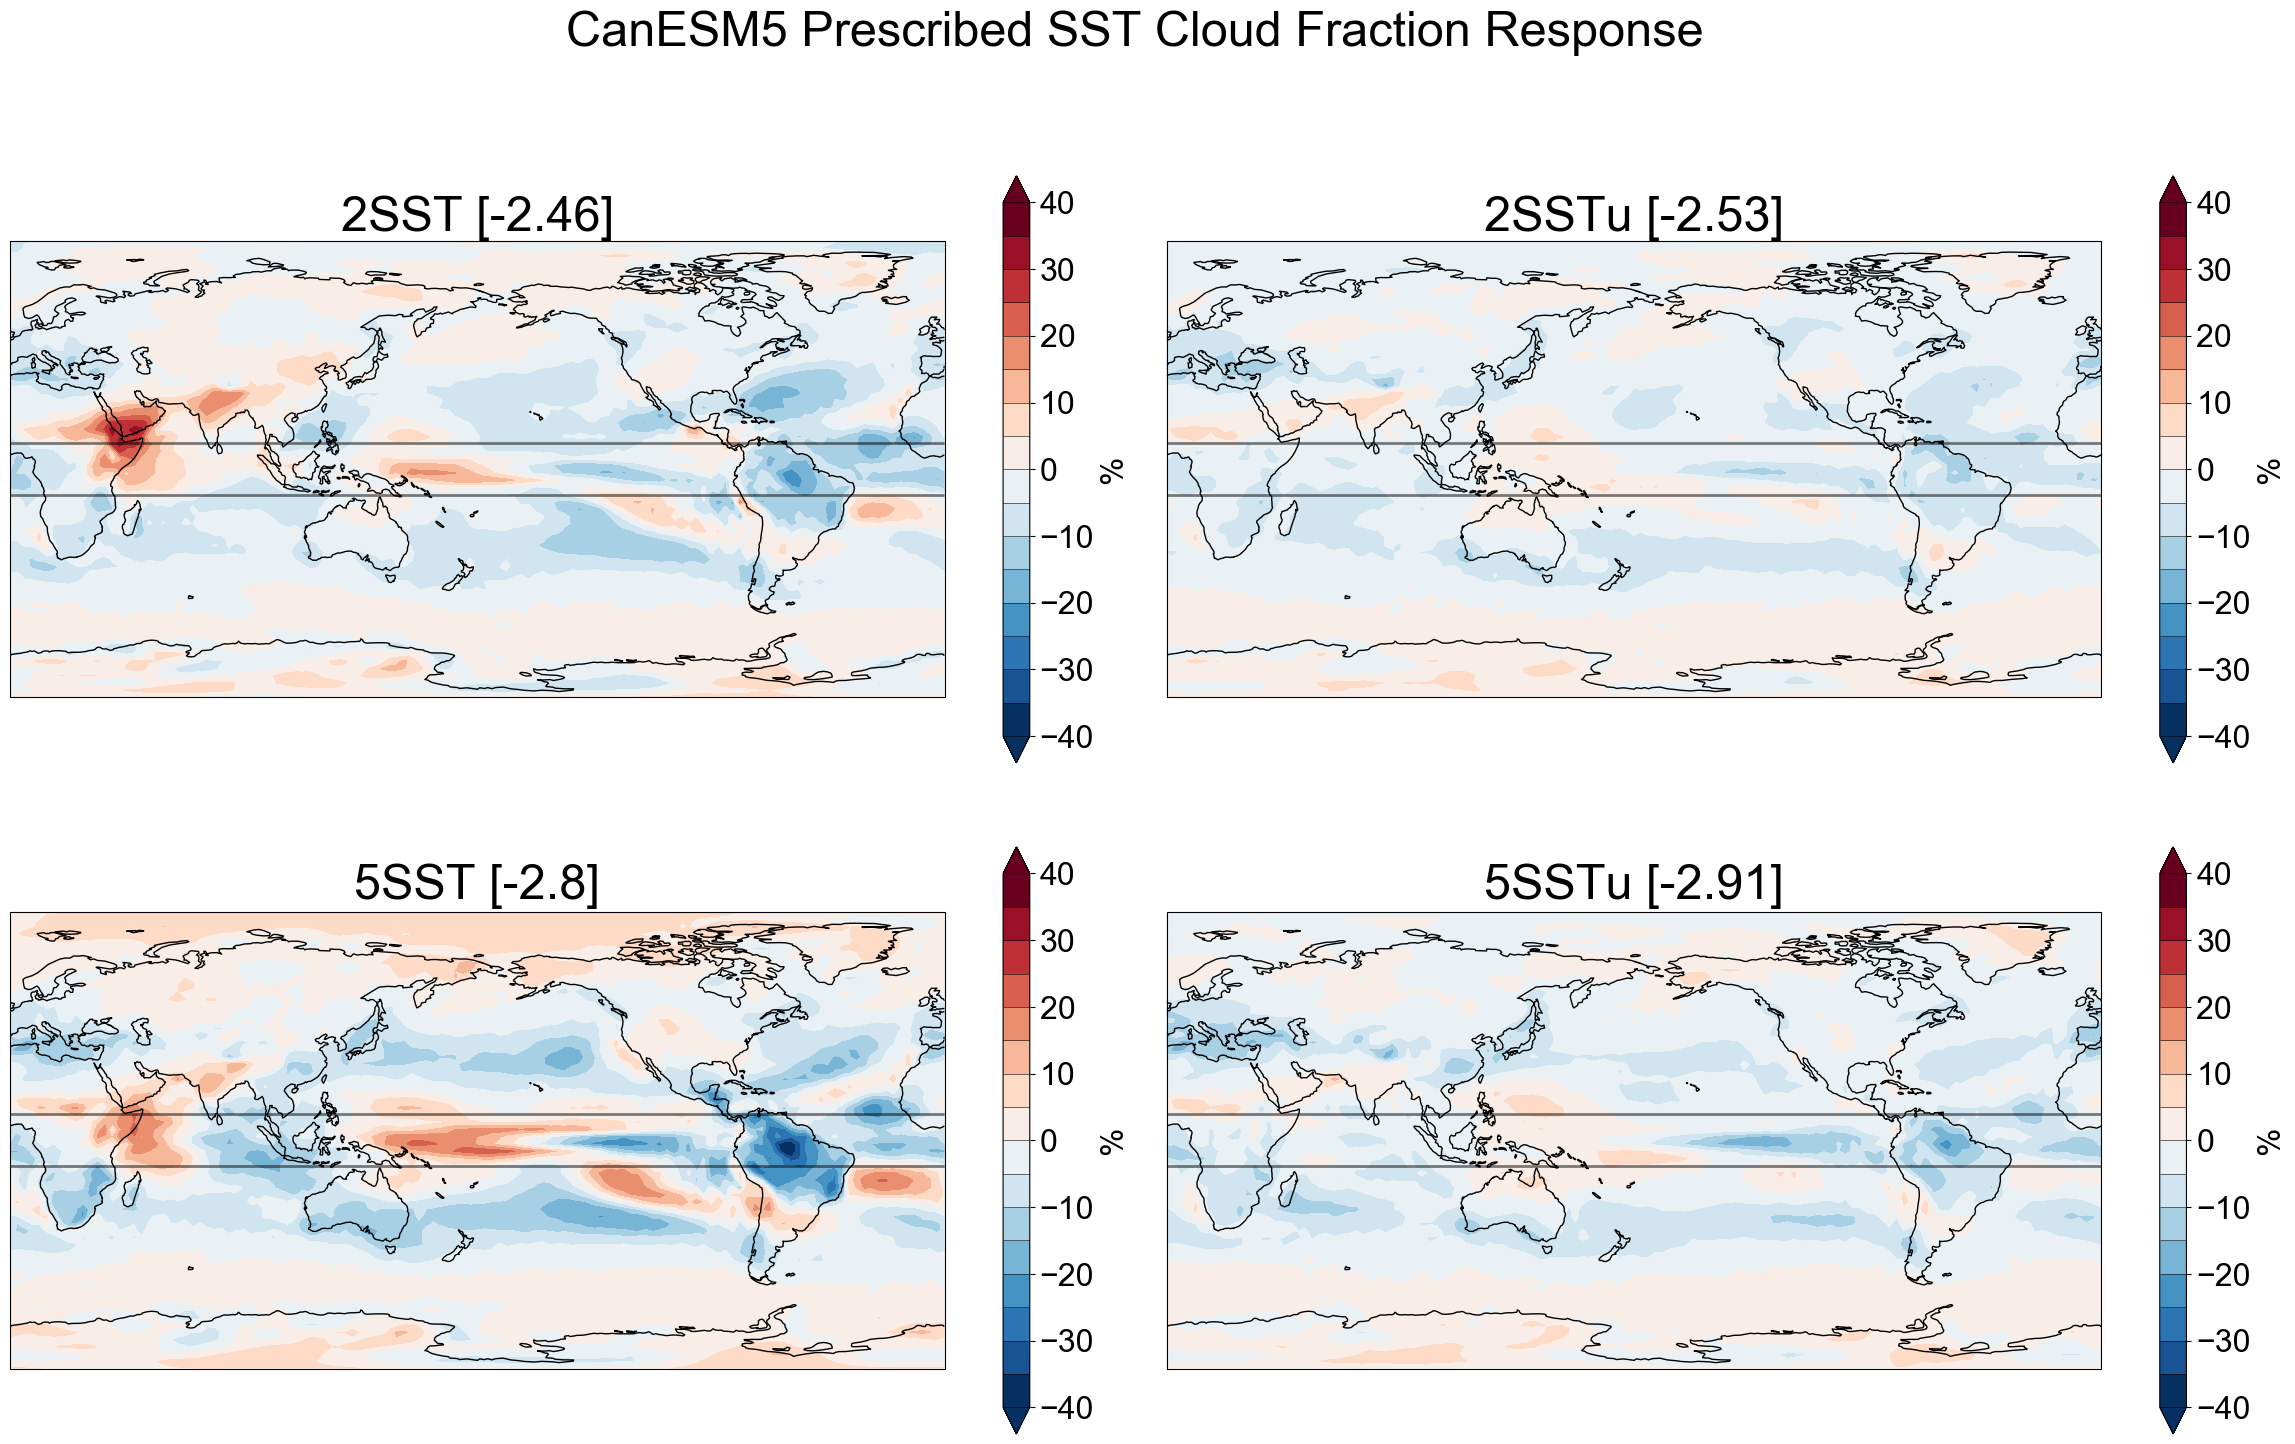

In [14]:
mpl.rc('font',size=23,**{'family':'sans-serif','sans-serif':['Arial']})
bounds_diff = np.arange(-40,41,5)
bounds_diff_ticks = np.arange(-40,41,10)
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

cmap = plt.cm.RdBu_r
norm_diff = mpl.colors.BoundaryNorm(bounds_diff, cmap.N)

exps = list(dCLD.keys())
fig = plt.figure(figsize=(30,20),dpi=100)
plt.suptitle('CanESM5 Prescribed SST Cloud Fraction Response',fontsize=35,y=0.9)
#gs = gridspec.GridSpec(3,2, width_ratios=[0.6,1],height_ratios=[1,1,1])

ax = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=0.5, linestyle='-')
g.xlabels_top = False
g.xlabels_bottom = False
g.ylabels_left = False
g.ylabels_right = False
g.xlines = False
g.ylocator = mticker.FixedLocator([-10, 10])
g.yformatter = LATITUDE_FORMATTER
ax.set_title(exps[0]+' [{}]'.format(round(dCLD_gam[exps[0]],2)),fontsize=35,pad=0.1)
im = ax.contourf(lon_cyc,lat,dCLD_plot[exps[0]],bounds_diff,cmap=cmap,norm=norm_diff,extend='both')
ax.coastlines()
plt.colorbar(im,ticks=bounds_diff_ticks,drawedges=True,label='%',shrink=0.7)

ax1 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
g1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=0.5, linestyle='-')
g1.xlabels_top = False
g1.xlabels_bottom = False
g1.ylabels_left = False
g1.ylabels_right = False
g1.xlines = False
g1.ylocator = mticker.FixedLocator([-10, 10])
g1.yformatter = LATITUDE_FORMATTER
ax1.set_title(exps[1]+' [{}]'.format(round(dCLD_gam[exps[1]],2)),fontsize=35)
im1 = ax1.contourf(lon_cyc,lat,dCLD_plot[exps[1]],bounds_diff,cmap=cmap,norm=norm_diff,extend='both')
ax1.coastlines()
plt.colorbar(im1,ticks=bounds_diff_ticks,drawedges=True,label='%',shrink=0.7)

ax2 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
g2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=0.5, linestyle='-')
g2.xlabels_top = False
g2.xlabels_bottom = False
g2.ylabels_left = False
g2.ylabels_right = False
g2.xlines = False
g2.ylocator = mticker.FixedLocator([-10, 10])
g2.yformatter = LATITUDE_FORMATTER
ax2.set_title(exps[2]+' [{}]'.format(round(dCLD_gam[exps[2]],2)),fontsize=35,pad=10)
im2 = ax2.contourf(lon_cyc,lat,dCLD_plot[exps[2]],bounds_diff,cmap=cmap,norm=norm_diff,extend='both')
ax2.coastlines()
plt.colorbar(im2,ticks=bounds_diff_ticks,drawedges=True,label='%',shrink=0.7)

ax3 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
g3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=0.5, linestyle='-')
g3.xlabels_top = False
g3.xlabels_bottom = False
g3.ylabels_left = False
g3.ylabels_right = False
g3.xlines = False
g3.ylocator = mticker.FixedLocator([-10, 10])
g3.yformatter = LATITUDE_FORMATTER
ax3.set_title(exps[3]+' [{}]'.format(round(dCLD_gam[exps[3]],2)),fontsize=35,pad=10)
im3 = ax3.contourf(lon_cyc,lat,dCLD_plot[exps[3]],bounds_diff,cmap=cmap,norm=norm_diff,extend='both')
ax3.coastlines()
plt.colorbar(im3,ticks=bounds_diff_ticks,drawedges=True,label='%',shrink=0.7)

plt.subplots_adjust(wspace=-0.01,hspace=-0.2)

plt.savefig('CanESM5_Custom_CLD.png',bbox_inches='tight')